## Lesson 4 assignment
Robert Lisy

In [1]:
import pandas as pd
import numpy as np
import requests
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

filename = f"data/thyroid.csv"

# We're going to import the thyroid data set from UCI
# https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

download_if_not_exists("https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/hypothyroid.data",
                      filename)
                        
# import the CSV as a data set
df = pd.read_csv(filename, header=None)
df.head()
df.shape

(3163, 26)

In [2]:
# now that we have the data frame, let's rename to sensible values
# names for this data set are here
# hypothyroid.names
colnames = {0 : 'hypothyroid', 1: 'age', 2: 'sex', 3:'on_thyroxine', 4:'query_on_thyroxine',
       5:'on_antithyroid_medication', 6:'thyroid_surgery', 7:'query_hypothyroid', 8:'query_hyperthyroid',
       9:'pregnant', 10:'sick', 11:'tumor', 12:'lithium', 13:'goitre', 14:'TSH_measured', 15:'TSH',
       16:'T3_measured', 17:'T3', 18:'TT4_measured', 19:'TT4', 20:'T4U_measured', 21:'T4U', 
       22:'FTI_measured', 23:'FTI', 24:'TBG_measured', 25:'TBG'}
            
            
df.rename(columns = colnames, inplace=True)
df.head()

,hypothyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,...,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,...,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,...,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,...,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,...,y,1.20,y,57,y,1.28,y,44,n,?


### Data Cleaning and Conversion

In [3]:
# Convert some columns the their approperiate type
# and drop others (since I have no idea what they mean, and they're not necessary for the excercise)

# convert the categorical variables over to categories
category_list = ['hypothyroid', 'sex', 'on_thyroxine', 'on_antithyroid_medication', 'thyroid_surgery',
                'pregnant', 'sick', 'tumor', 'lithium', 'goitre', 'TSH_measured', 'T3_measured',
                 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured']
for col in category_list:
    df[col] = df[col].astype('category')
    
# convert numeric cols to numeric.
numeric_list = ['age', 'TSH', 'T3', 'TT4', 'T4U',
               'FTI', 'TBG']
for col in numeric_list:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Drop all these columns which start with 'query'
df = df.loc[:, ~df.columns.str.startswith('query')]

# Drop a few more columns as they're not necessary for the excercise
drops = ['T3_measured', 'T3', 'TT4_measured', 'TT4',
        'T4U_measured', 'T4U', 'FTI_measured', 'FTI',
        'goitre', 'TBG_measured', 'TBG']

df = df.drop(drops, axis=1)

# Check output to see that the types are right.
df.dtypes

hypothyroid                  category
age                           float64
sex                          category
on_thyroxine                 category
on_antithyroid_medication    category
thyroid_surgery              category
pregnant                     category
sick                         category
tumor                        category
lithium                      category
TSH_measured                 category
TSH                           float64
dtype: object

In [4]:
# See how many NaN values there are
# There will be many replacements in Age (446) and TSH (468)
df.isna().sum()

hypothyroid                    0
age                          446
sex                            0
on_thyroxine                   0
on_antithyroid_medication      0
thyroid_surgery                0
pregnant                       0
sick                           0
tumor                          0
lithium                        0
TSH_measured                   0
TSH                          468
dtype: int64

In [5]:
# For the TSH column we will fill all NaNs with a 0
# This would signify that they haven't received a test.
df['TSH'] = df['TSH'].fillna(0)

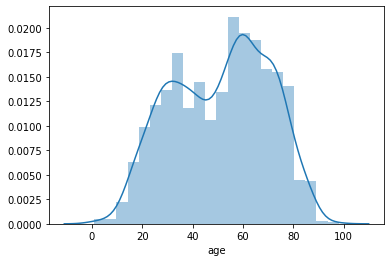

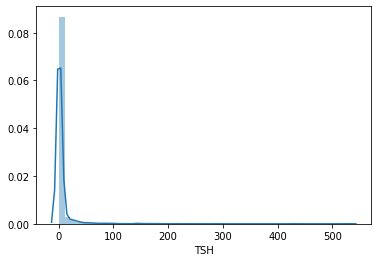

In [6]:
# Check out histograms of numeric columns
plot_cols = ['age','TSH']

for col in plot_cols:
    sns.distplot(df[col]);
    plt.show()

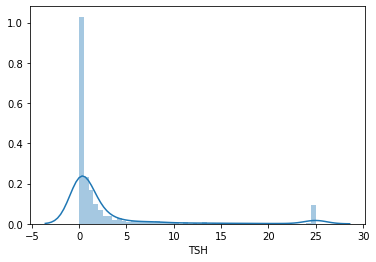

In [7]:
# Looks like TSH (thyroid stimulating hormone) has some crazy outliers in it.
# Since this is a disease model, we should cap them with a uniform number that is still
# very high. 
# This accomplishes a few things:
# - It doesn't lose the information that these are 'abnormal' values (which may indicate disease)
# - It helps later down the line with any potential modeling, since the new value should be 
#    much closer to the top of a "normal" range. I chose the number 25 for this,
#    as a normal range for TSH is usually lower than 10

df['TSH'].values[df['TSH'].values >= 25] = 25

sns.distplot(df['TSH']);
plt.show()

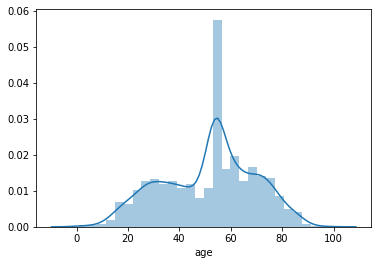

In [8]:
# Now we have to clean the age column by filling any extreme values or NaNs with the median
age_median = np.nanmedian(df['age'])
df['age'] = np.nan_to_num(df['age'], nan = age_median)

sns.distplot(df['age']);
plt.show()

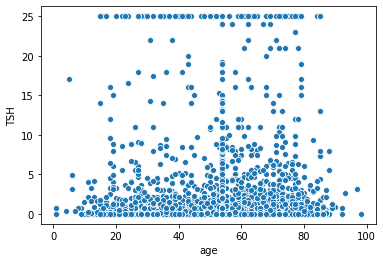

In [9]:
# Fill out the rest of the needs for the assignment
sns.scatterplot(df['age'], df['TSH']);
plt.show()

In [10]:
# Print the std deviation for numerics
for col in plot_cols:
    std = np.std(df[col])
    print('Standard deviation for ' + str(col) + ' is ' + str(std))


Standard deviation for age is 17.906553131791483
Standard deviation for TSH is 5.9751969609011315


### Summary

- Both age and TSH had outliers, which were identified through visual inspection and categorization of missing values.
- TSH required imputation via 'capping' where we set a ceiling, above which very high values are rounded down to the ceiling.
- Age required imputation via substitution of median for missing values. This makes the most sense since the best 'guess' anyone could make about an unknown age is the most common age of the population or sample.
- I histogrammed the age and TSH columns, since I wanted to know their distributions.
- As this was a large data set, I removed attributes where I didn't know their meaning ('query_'), those where the meaning was clear but I already had a large amount of data (non TSH test results such as T3, T4U, etc), and categorical variables which were unintersting ('goiter' is not super clinically relevant for thyroid disease, as it's already detected via TSH).
- I actually kept all rows. If this was later used in a modeling excercise, I would consider throwing out rows where we lacked age _AND_ TSH, or some other measure of a "junky" row.